Youngs_modulus: 1000.3665161132812: 100%|██████████| 500/500 [00:53<00:00,  9.33it/s]


Time taken by adam: 53.58390808105469
parameter = 1000.3665161132812 and loss = 0.004986115265637636


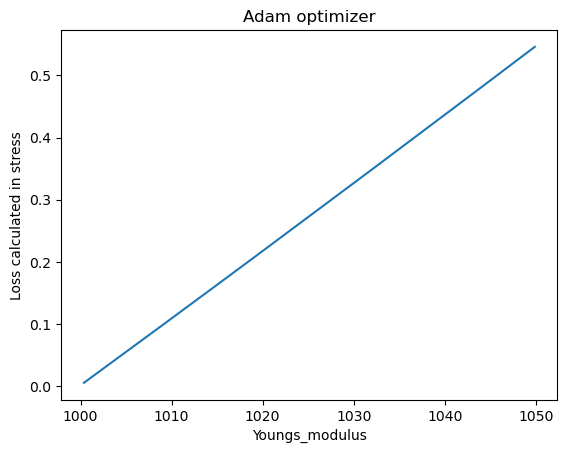

|   iter    |  target   | youngs... |
-------------------------------------
| 1         | -0.1767   | 983.4     |
| 2         | -0.4804   | 1.044e+03 |
| 3         | -1.019    | 900.0     |
| 4         | -0.1635   | 984.7     |
| 5         | -1.108    | 1.1e+03   |
| 6         | -0.1306   | 1.012e+03 |
| 7         | -0.002043 | 1e+03     |
| 8         | -0.5549   | 947.0     |
Time taken by Bayesian Optimization: 3.81498646736145
{'target': -0.0020428309217095375, 'params': {'youngs_modulus': 1000.1903192810634}}


In [10]:
import sys,os
sys.path.append(os.path.abspath('../'))
from diffmpm.material import SimpleMaterial, LinearElastic
from diffmpm.particle import Particles
from diffmpm.element import Quadrilateral4Node
from diffmpm.constraint import Constraint
from diffmpm.mesh import Mesh2D
from diffmpm.solver import MPMExplicit
import jax.numpy as jnp
import numpy as np
from jax import jit, value_and_grad
import optax
from tqdm import tqdm
import time
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
mesh_config = {}
density = 1
poisson_ratio = 0.0
youngs_modulus = 1000
# Linear Elastic Material with given parameters
material = LinearElastic(
    {
        "id": 0,
        "youngs_modulus": youngs_modulus,
        "density": density,
        "poisson_ratio": poisson_ratio,
    }
)
# location of the material points
particle_loc = jnp.array([[0.0, 0.0], [0.5, 0.0], [0.0, 0.5], [0.5, 0.5]]).reshape(
    4, 1, 2
)
# particle object for material points
particles = Particles(
    particle_loc, material, jnp.zeros(particle_loc.shape[0], dtype=jnp.int32)
)
particles.velocity = particles.velocity.at[:].set(0.0)
# velocity constraint for material point at (0,0)
constraints = [(0, Constraint(1, 0.0))]
# gravity loading
gravity_loading = jnp.array([0.0, -9.8]).reshape(1, 2)
element = Quadrilateral4Node([1, 1], 1, [1, 1], constraints)
mesh_config["particles"] = [particles]
mesh_config["elements"] = element
mesh_config["particle_surface_traction"] = []
mesh = Mesh2D(mesh_config)
solver = MPMExplicit(mesh, 0.01, sim_steps=10)
# getting the target value for youngs modulus 1000
target_ans = solver.solve_jit(gravity_loading)


# using adam optimizer
@jit
def compute_loss(youngs_modulus, solver, target_stress):
    # creating a particle object with the given youngs modulus in the function
    material_props = solver.mesh.particles[0].material.properties
    material_props["youngs_modulus"] = youngs_modulus
    #updating the mesh object
    solver.mesh.particles[0].material = LinearElastic(material_props)
    gravity_loading = jnp.array([0.0, -9.8]).reshape(1, 2)
    solver.mesh.particles[0].velocity = solver.mesh.particles[0].velocity.at[:].set(0.0)
    #solving for the given youngs_modulus and computing the loss with the expected stress
    result = solver.solve_jit(gravity_loading)
    #using stress to calculate loss
    loss = jnp.linalg.norm(result["stress"] - target_stress)
    return loss

#adam optimizer
def optax_adam(params, niter, mpm, target_stress):
    start_alpha = 0.1
    optimizer = optax.adam(start_alpha)
    opt_state = optimizer.init(params)
    param_list = []
    loss_list = []
    t = tqdm(range(niter), desc=f"Youngs_modulus: {params}")
    for _ in t:
        lo, grads = value_and_grad(compute_loss)(params, mpm, target_stress)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        t.set_description(f"Youngs_modulus: {params}")
        param_list.append(params)
        loss_list.append(lo)
    return param_list, loss_list

#initial guess for the youngs modulus
params = 1050.0
#measuring the time taken by the optimizer
start_t = time.time()
#calling the optimizer
parameter_list, loss_list = optax_adam(params, 500, solver, target_ans["stress"])
end_time = time.time()
print(f"Time taken by adam: {end_time-start_t}")
print(f"parameter = {parameter_list[-1]} and loss = {loss_list[-1]}")
plt.plot(parameter_list,loss_list)
plt.xlabel("Youngs_modulus")
plt.ylabel("Loss calculated in stress")
plt.title("Adam optimizer")
plt.show()
# Using Bayesian Optimization model based on gaussian processes maximizes the
#given function using probability distributions

#target stress for the given youngs modulus
target_stress = target_ans["stress"]

#loss function for bayesian optimization
@jit
def loss_func(youngs_modulus, solver=solver, target_stress=target_stress):
    material_props = solver.mesh.particles[0].material.properties
    material_props["youngs_modulus"] = youngs_modulus
    solver.mesh.particles[0].material = LinearElastic(material_props)
    external_loading_local = jnp.array([0.0, -9.8]).reshape(1, 2)
    result = solver.solve_jit(external_loading_local)
    stress = result["stress"]
    loss = jnp.linalg.norm(stress - target_stress)
    #returning negative of the loss as bayesian optimizer maximizes the function
    return -loss

#giving bound to the value of the youngs_modulus for bayesian optimizer
pbounds = {"youngs_modulus": (900, 1100)}
optimizer = BayesianOptimization(
    f=loss_func, pbounds=pbounds, random_state=1, verbose=2
)
#measuring the time taken by the optimizer
start_t = time.time()
#calling the optimizer, init_points is the number of random points to be sampled
#n_iter is the number of iterations to be performed
optimizer.maximize(init_points=3, n_iter=5)
end_time = time.time()
print(f"Time taken by Bayesian Optimization: {end_time-start_t}")
print(optimizer.max)
